In [125]:
import numpy as np
import pathlib
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
import PIL
import tensorflow as tf
# from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [127]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [128]:
data_dir = pathlib.Path('./input/data/Training_data')  

In [129]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

600


In [130]:
driving_license = list(data_dir.glob('driving_license/*'))
social_security = list(data_dir.glob('social_security/*'))
others = list(data_dir.glob('others/*'))

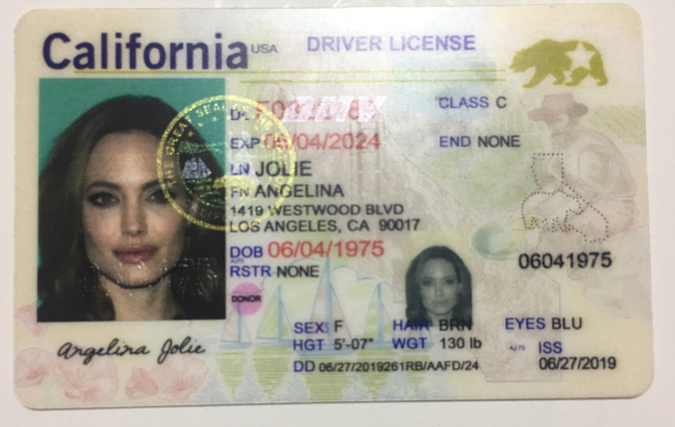

In [131]:
PIL.Image.open(str(driving_license[9]))

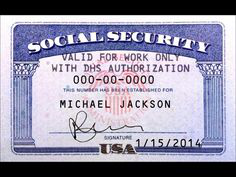

In [132]:
PIL.Image.open(str(social_security[9]))

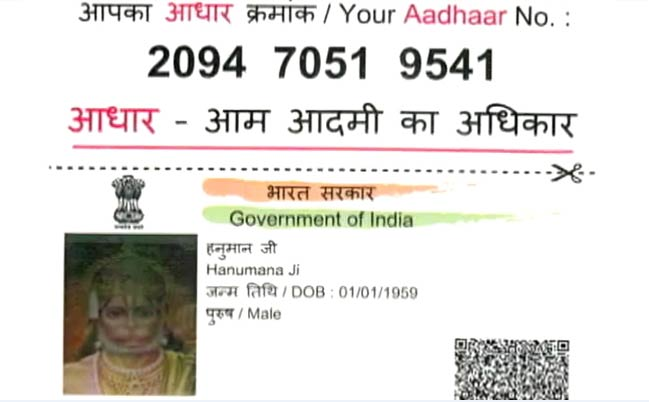

In [133]:
PIL.Image.open(str(others[9]))

In [134]:
batch_size = 32
img_height = 180
img_width = 180

In [135]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 600 files belonging to 3 classes.
Using 480 files for training.


In [136]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size 
)

Found 600 files belonging to 3 classes.
Using 120 files for validation.


In [137]:
class_names = train_ds.class_names
print(class_names)

['driving_license', 'others', 'social_security']


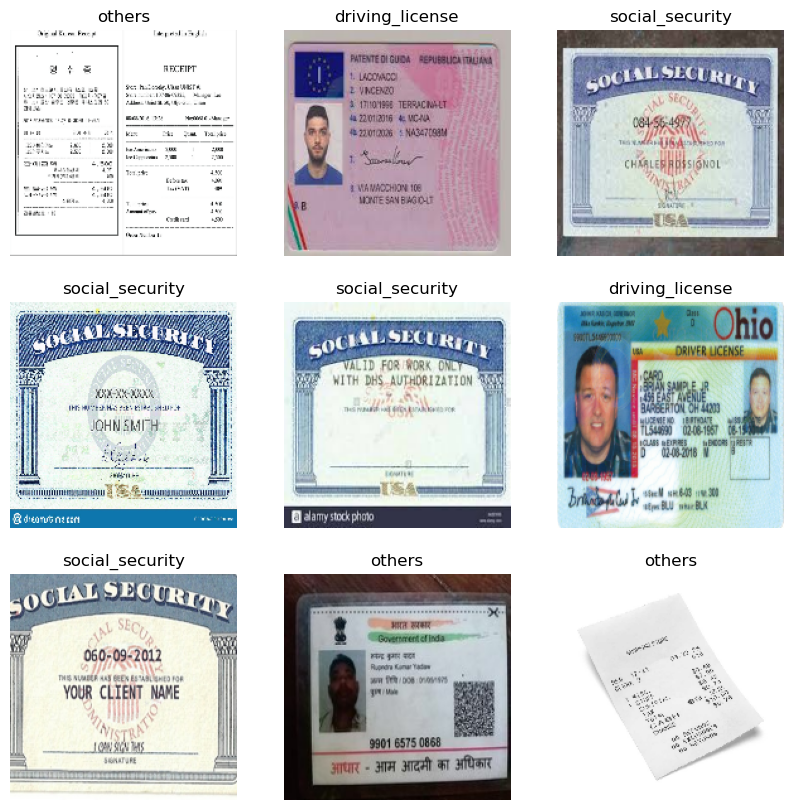

In [138]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [139]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [140]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [141]:
normalization_layer = layers.Rescaling(1./255)

In [142]:
def normalize(x, y):
    x = normalization_layer(x)
    return x, y

normalized_ds = train_ds.map(normalize)
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.02023985 0.77623665


In [143]:
# normalied_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalied_ds))
# first_image = image_batch[0]
# print(np.min(first_image), np.max(first_image))

#### Defining the model architecture

In [144]:
num_classes = len(class_names)

with tf.device('/GPU:0'):
  model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
  ])

using SparseCategoricalCrossentropy because after flattening the arrayt contains a lot of zero's

In [145]:
model.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [146]:
epochs=20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
15/15 [==============================] - 1s 72ms/step - loss: 1.5875 - accuracy: 0.3250 - val_loss: 1.0435 - val_accuracy: 0.4333
Epoch 2/20
15/15 [==============================] - 1s 42ms/step - loss: 0.8079 - accuracy: 0.7250 - val_loss: 0.5033 - val_accuracy: 0.8500
Epoch 3/20
15/15 [==============================] - 1s 39ms/step - loss: 0.3850 - accuracy: 0.8417 - val_loss: 0.3690 - val_accuracy: 0.8667
Epoch 4/20
15/15 [==============================] - 1s 47ms/step - loss: 0.1924 - accuracy: 0.9167 - val_loss: 0.2952 - val_accuracy: 0.9083
Epoch 5/20
15/15 [==============================] - 1s 38ms/step - loss: 0.1162 - accuracy: 0.9583 - val_loss: 0.2485 - val_accuracy: 0.9417
Epoch 6/20
15/15 [==============================] - 1s 38ms/step - loss: 0.0720 - accuracy: 0.9813 - val_loss: 0.1790 - val_accuracy: 0.9417
Epoch 7/20
15/15 [==============================] - 1s 39ms/step - loss: 0.0481 - accuracy: 0.9854 - val_loss: 0.3057 - val_accuracy: 0.9417
Epoch 8/20
15

In [147]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 45, 45, 64)       

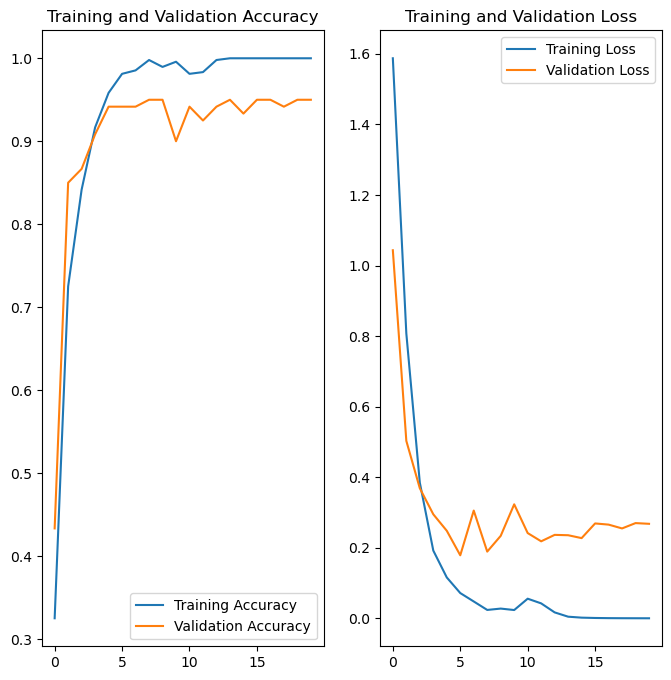

In [148]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1 )
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2 )
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [149]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

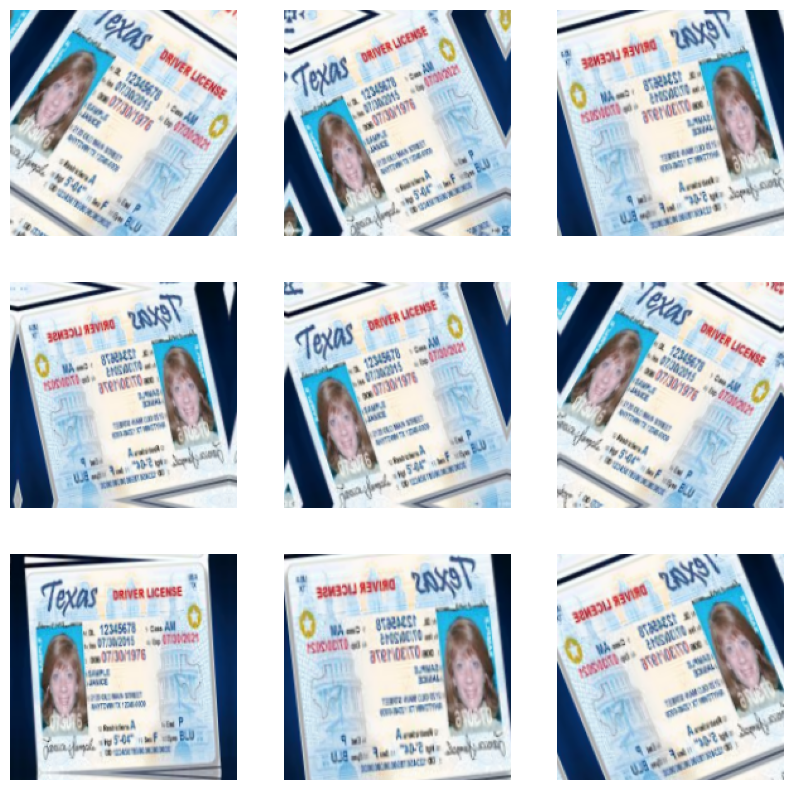

In [150]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [151]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [152]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [153]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [154]:
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
15/15 [==============================] - 2s 84ms/step - loss: 1.5386 - accuracy: 0.3292 - val_loss: 1.0589 - val_accuracy: 0.4917
Epoch 2/30
15/15 [==============================] - 1s 67ms/step - loss: 0.9806 - accuracy: 0.5646 - val_loss: 0.8016 - val_accuracy: 0.7333
Epoch 3/30
15/15 [==============================] - 1s 64ms/step - loss: 0.7451 - accuracy: 0.7146 - val_loss: 0.9616 - val_accuracy: 0.6167
Epoch 4/30
15/15 [==============================] - 1s 64ms/step - loss: 0.5802 - accuracy: 0.7750 - val_loss: 0.4963 - val_accuracy: 0.8250
Epoch 5/30
15/15 [==============================] - 1s 59ms/step - loss: 0.4878 - accuracy: 0.8188 - val_loss: 0.4491 - val_accuracy: 0.8000
Epoch 6/30
15/15 [==============================] - 1s 59ms/step - loss: 0.3327 - accuracy: 0.8813 - val_loss: 0.8270 - val_accuracy: 0.6833
Epoch 7/30
15/15 [==============================] - 1s 58ms/step - loss: 0.3576 - accuracy: 0.8500 - val_loss: 0.4675 - val_accuracy: 0.7917
Epoch 8/30
15

In [155]:
model.save('output/cnn-model.h5')

In [156]:
model = tf.keras.models.load_model('output/cnn-model.h5')

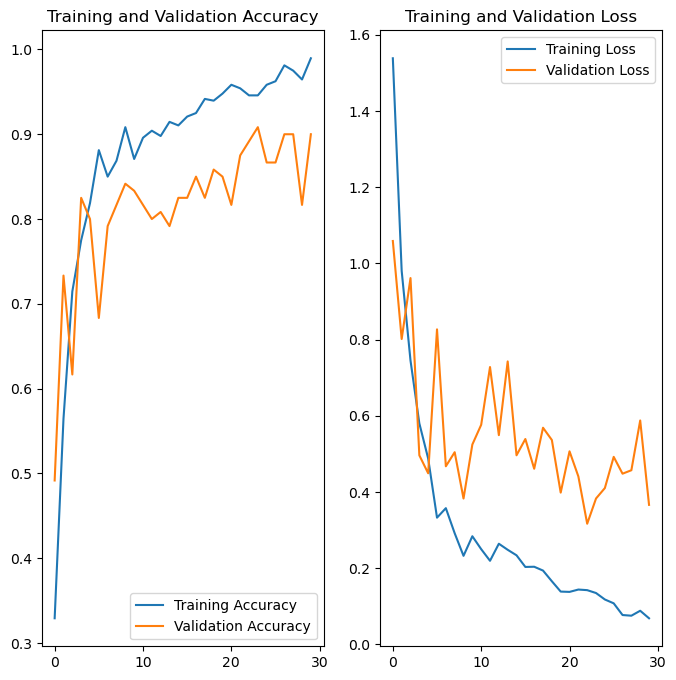

In [157]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1 )
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2 )
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction

In [158]:
test_data = pathlib.Path('./Input/data/Testing_Data//')

In [159]:
image_count = len(list(test_data.glob('*/*')))
print(image_count)

150


In [160]:
test_driving_license = list(data_dir.glob('driving_license/*'))
test_social_security = list(data_dir.glob('social_security/*'))
test_others = list(data_dir.glob('others/*'))

In [161]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 150 files belonging to 3 classes.


2023-05-02 13:55:36.001607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


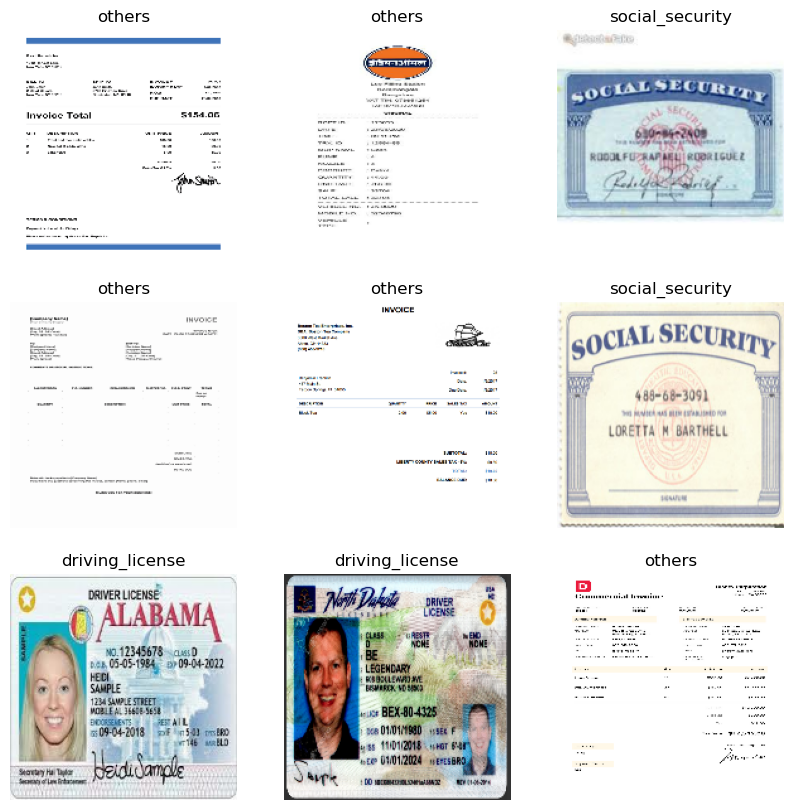

In [162]:
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [163]:
model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 1s - loss: 0.1892 - accuracy: 0.8750

2023-05-02 13:55:36.641742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5/5 [==============================] - 0s 21ms/step - loss: 0.2806 - accuracy: 0.9000


[0.28057804703712463, 0.9000000357627869]

In [164]:
img = tf.keras.utils.load_img(
    'input/data/Testing_Data/driving_license/10.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

In [165]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print('This image most likely belongs to {} with a {:2f} percent confidence.'
      .format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 60ms/step
This image most likely belongs to driving_license with a 99.966085 percent confidence.
